In [1]:
import sys
sys.path.append("..")

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from datasets import load_dataset
from transformers import pipeline
from src.models.sentiment_model import SentimentModel 
import warnings
warnings.filterwarnings("ignore")

plt.style.use("ggplot")
%matplotlib inline

/Users/cynthia/Desktop/sentiment-analysis-mlops/mlops/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
dataset = load_dataset("glue", "sst2")

print(dataset.items(), "\n")
print(f"Dataset info:")
print(f"Training samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['validation'])}")
print(f"Test samples: {len(dataset['test'])}")

<class 'datasets.dataset_dict.DatasetDict'>
dict_items([('train', Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 67349
})), ('validation', Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 872
})), ('test', Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 1821
}))]) 

Dataset info:
Training samples: 67349
Validation samples: 872
Test samples: 1821


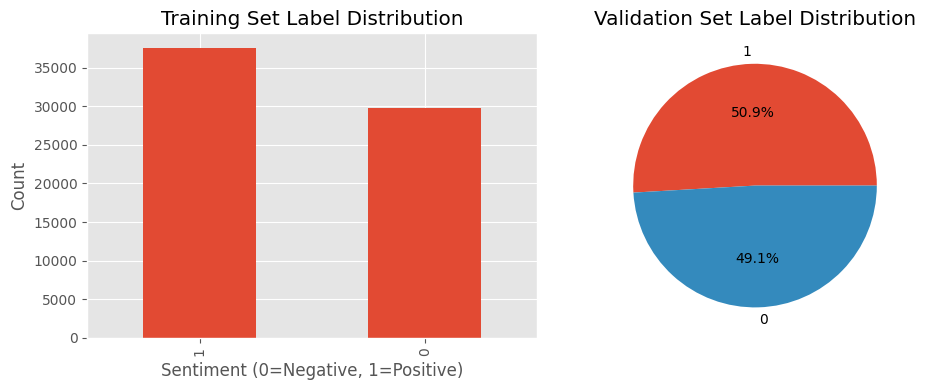

In [6]:
train_df = pd.DataFrame(dataset["train"])
val_df = pd.DataFrame(dataset["validation"])

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
train_df["label"].value_counts().plot(kind="bar")
plt.title("Training Set Label Distribution")
plt.xlabel("Sentiment (0=Negative, 1=Positive)")
plt.ylabel("Count")

plt.subplot(1,2,2)
val_df["label"].value_counts().plot(kind="pie", autopct='%1.1f%%')
plt.title("Validation Set Label Distribution")
plt.ylabel("")

plt.tight_layout()
plt.show()

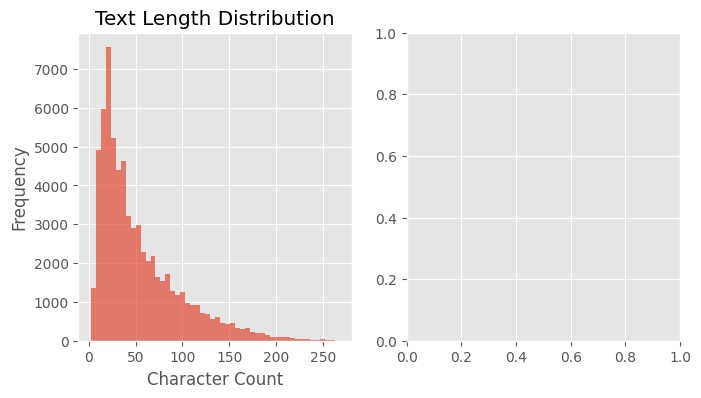

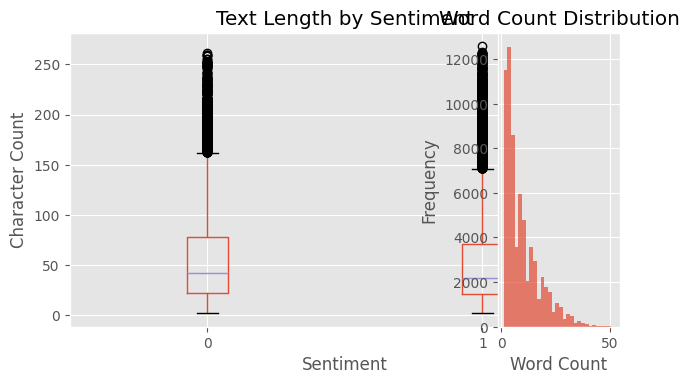

In [7]:
train_df['text_length'] = train_df['sentence'].str.len()
val_df['text_length'] = val_df['sentence'].str.len()

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
train_df['text_length'].hist(bins=50, alpha=0.7)
plt.title('Text Length Distribution')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.subplot(1,3,2)
train_df.boxplot(column='text_length', by='label')
plt.title('Text Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Character Count')
plt.suptitle('')

plt.subplot(1,3,3)
train_df['word_count'] = train_df['sentence'].str.split().str.len()
train_df['word_count'].hist(bins=30, alpha=0.7)
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [8]:
models_to_compare = [
    "distilbert-base-uncased-finetuned-sst-2-english",
    "cardiffnlp/twitter-roberta-base-sentiment",
    "nlptown/bert-base-multilingual-uncased-sentiment"
]

comparison_results = []

test_sentences = [
    "This movie was absolutely fantastic!",
    "I really hate this experience",
    "The product is okay, nothing special.",
    "Best purchase I've ever made!",
    "Terrible service, would not recommend."
]

for model_name in models_to_compare:
    try:
        classifier = pipeline("sentiment-analysis", model=model_name)
        for sentence in test_sentences:
            result = classifier(sentence)[0]
            comparison_results.append({
                "model": model_name.split("/")[-1],
                "text": sentence,
                "label": result["label"],
                "score": result["score"]
            })
    except Exception as e:
        print(f"Error with {model_name}: {e}")

comparison_df = pd.DataFrame(comparison_results)
pivot_df = comparison_df.pivot_table(
    index="text",
    columns="model",
    values="score",
    aggfunc="first"
)

config.json: 100%|██████████| 747/747 [00:00<00:00, 2.47MB/s]
pytorch_model.bin: 100%|██████████| 499M/499M [00:55<00:00, 8.95MB/s] 
vocab.json: 899kB [00:00, 12.7MB/s]
merges.txt: 456kB [00:00, 11.3MB/s]
config.json: 100%|██████████| 953/953 [00:00<00:00, 2.97MB/s]
model.safetensors: 100%|██████████| 669M/669M [01:14<00:00, 9.00MB/s] 
tokenizer_config.json: 100%|██████████| 39.0/39.0 [00:00<00:00, 98.5kB/s]
vocab.txt: 872kB [00:00, 16.2MB/s]
special_tokens_map.json: 100%|██████████| 112/112 [00:00<00:00, 373kB/s]


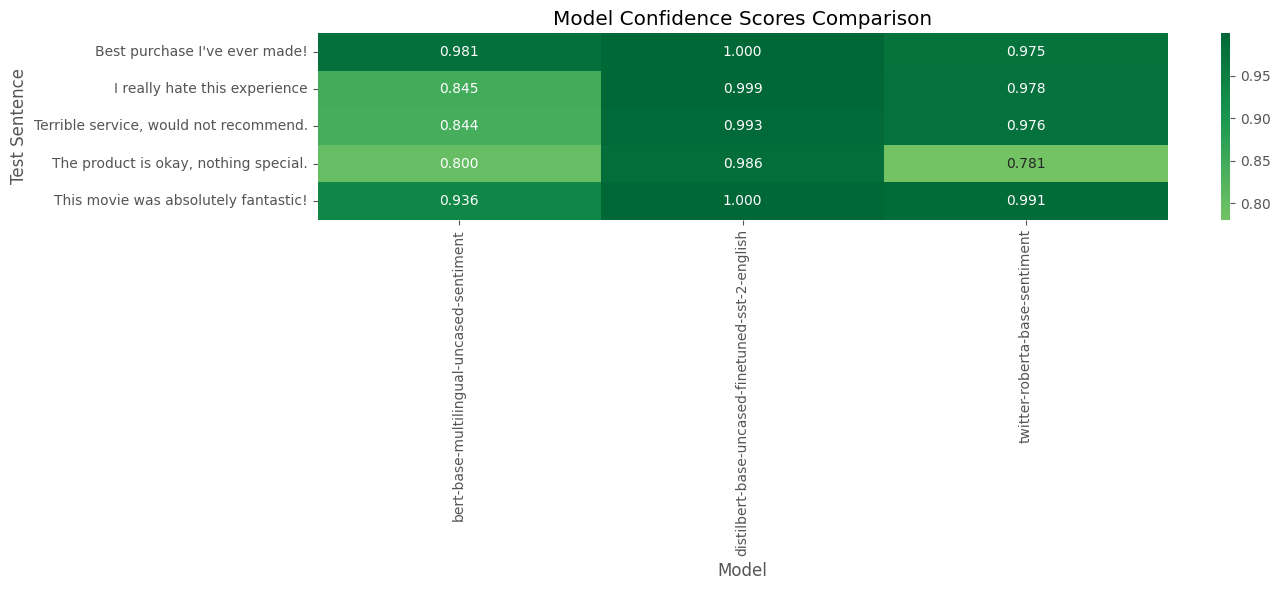

In [9]:
plt.figure(figsize=(14,6))
sns.heatmap(pivot_df, annot=True, fmt=".3f", cmap="RdYlGn", center=0.5)
plt.title("Model Confidence Scores Comparison")
plt.xlabel("Model")
plt.ylabel("Test Sentence")
plt.tight_layout()
plt.show()

In [ ]:
# performance benchmarking

import time

model = SentimentModel()

batch_sizes = [1, 8, 16, 32, 64]
performance_results = []

test_texts = train_df["sentence"].sample(100).tolist()

for batch_size in batch_sizes:
    batches = [test_texts[i:i+batch_size] for i in range(0, len(test_texts), batch_size)]

    start_time = time.time()
    for batch in batches:
        _ = model.predict(batch)
    total_time = time.time() - start_time

    performance_results.append({
        "batch_size": batch_size,
        "total_time": total_time,
        "samples_per_second": len(test_texts) / total_time,
        "avg_latency_ms": (total_time / len(test_texts)) * 1000
    })

    perf_df = pd.DataFrame(performance_results)

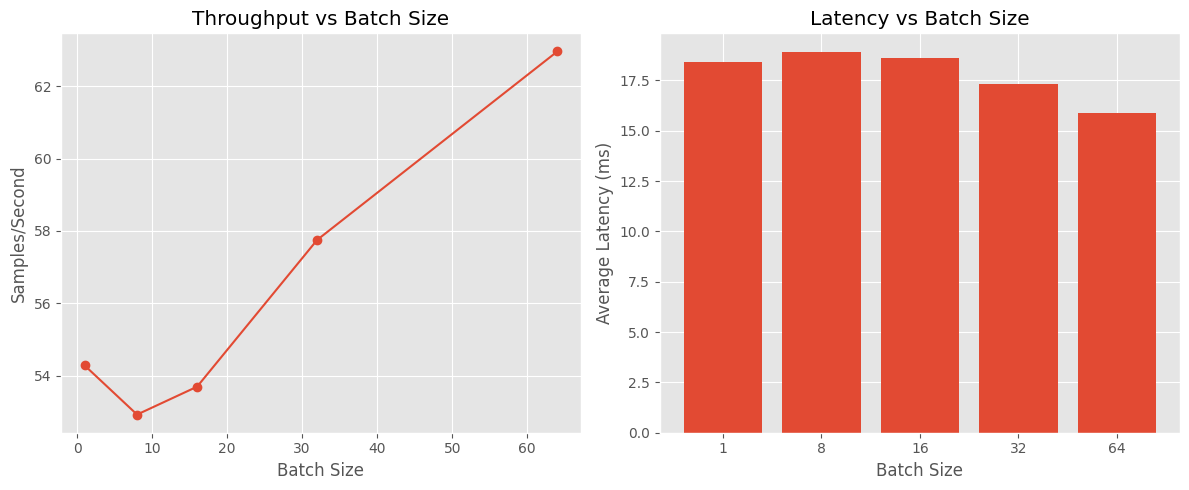

In [15]:
# visualize performance

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(perf_df["batch_size"], perf_df["samples_per_second"], "o-")
axes[0].set_xlabel("Batch Size")
axes[0].set_ylabel("Samples/Second")
axes[0].set_title("Throughput vs Batch Size")
axes[0].grid(True)

axes[1].bar(perf_df["batch_size"].astype(str), perf_df["avg_latency_ms"])
axes[1].set_xlabel("Batch Size")
axes[1].set_ylabel("Average Latency (ms)")
axes[1].set_title("Latency vs Batch Size")

plt.tight_layout()
plt.show()

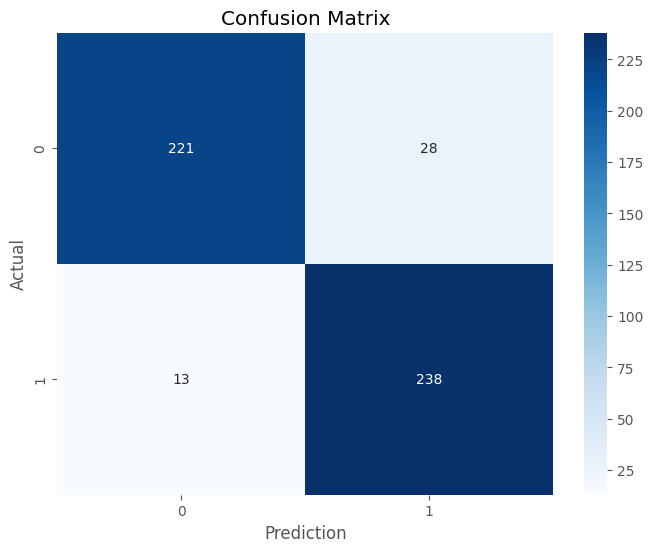

\Sample Misclassifications:
                                                                                                                                                              text true_label predicted  confidence
                                                                                                            rarely has leukemia looked so shimmering and benign .    negative  positive    0.977942
                                                                                                          we have n't seen such hilarity since say it is n't so !    positive  negative    0.944653
                this riveting world war ii moral suspense story deals with the shadow side of american culture : racial prejudice in its ugly and diverse forms .    negative  positive    0.999312
                                                                                  i do n't mind having my heartstrings pulled , but do n't treat me like a fool .    negative  positive    0

In [16]:
from sklearn.metrics import confusion_matrix

val_sample = val_df.sample(min(500, len(val_df)))
predictions = model.predict(val_sample["sentence"].tolist())

pred_labels = [1 if p["sentiment"] == "positive" else 0 for p in predictions]
true_labels = val_sample["label"].tolist()

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

errors = []
for i, (true, pred) in enumerate(zip(true_labels, pred_labels)):
    if true != pred:
        errors.append({
            "text": val_sample.iloc[i]["sentence"],
            "true_label": "positive" if true == 1 else "negative",
            "predicted": "positive" if pred == 1 else "negative",
            "confidence": predictions[i]["confidence"]
        })

error_df = pd.DataFrame(errors[:10])
print("\Sample Misclassifications:")
print(error_df.to_string(index=False))

In [18]:
perf_df.to_csv("../results/performance_analysis.csv", index=False)
error_df.to_csv("../results/error_analysis.csv", index=False)

print("✅ Analysis completed! Results saved to ../results/")

✅ Analysis completed! Results saved to ../results/
